In [1]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
import numpy as np
from skimage import io
import base64
import cv2
class FeatureExtractor:
    def __init__(self):
        base_model = VGG16(weights='imagenet')
        self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

    def extract(self, img):
        """
        Extract a deep feature from an input image
        Args:
            img: from PIL.Image.open(path) or tensorflow.keras.preprocessing.image.load_img(path)

        Returns:
            feature (np.ndarray): deep feature with the shape=(4096, )
        """
        img = img.resize((224, 224))  # VGG must take a 224x224 img as an input
        img = img.convert('RGB')  # Make sure img is color
        x = image.img_to_array(img)  # To np.array. Height x Width x Channel. dtype=float32
        x = np.expand_dims(x, axis=0)  # (H, W, C)->(1, H, W, C), where the first elem is the number of img
        x = preprocess_input(x)  # Subtracting avg values for each pixel
        feature = self.model.predict(x)[0]  # (1, 4096) -> (4096, )
        return feature / np.linalg.norm(feature)  # Normalize
    
    def get_from_link(self, img_link: str):
        image = io.imread(img_link)
        return self._extract(image)

    def get_from_image(self, img):
        image_bytes=base64.b64decode(img)
        image_np=np.frombuffer(image_bytes,dtype=np.uint8)
        img=cv2.imdecode(image_np,cv2.IMREAD_COLOR)
        return self._extract(img)


2024-10-02 16:33:45.539785: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-02 16:33:45.614437: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-02 16:33:45.616277: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-02 16:33:46.979273: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [29]:
from PIL import Image
img=Image.open("infra/data/mirflickr25k/mirflickr/im3.jpg")

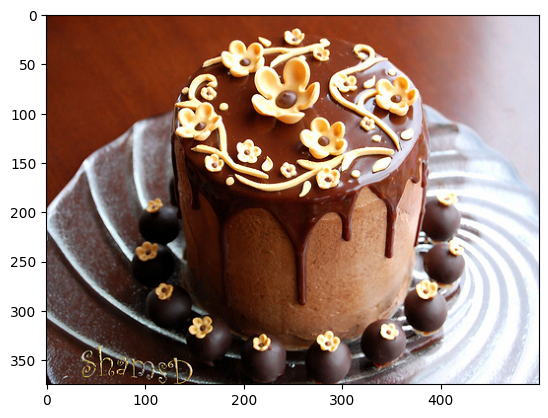

In [30]:
import matplotlib.pyplot as plt
plt.imshow(img)

In [31]:
fe=FeatureExtractor()
img=fe.extract(img)

1/1 [==============================] - 0s 189ms/step


In [32]:
print(img)

[0.        0.0524362 0.        ... 0.        0.        0.       ]


In [ ]:
import Backend.backend_config as config
from elasticsearch import Elasticsearch
from Backend.feature_extractor import FeatureExtractor
from PIL import Image
import io
import  base64
#Elasticsearch Client
client = Elasticsearch(
    [config.elastic_url], basic_auth=(config.elastic_usr, config.elastic_pass)
)
# Import FeatureExtractor Class
fe = FeatureExtractor()


def get_results_search_by_image(img, show_result):
    # Décoder l'image base64 en bytes
    
    img = base64.b64decode(img)
    img = Image.open(io.BytesIO(img))
    # Afficher l'image
    img.show()
    image_feature = fe.get_from_image(img)
    body = {
        "knn": {
            "field": "FeatureVector",
            "query_vector": image_feature,
            "k": 10,
            "num_candidates": 50,
        },
        "_source": ["OriginalURL"],
    }
    results = client.search(
        index=config.index_name, body=body, size=show_result
    )
    return {"resulttype": results}

#=======================================================================